<a href="https://colab.research.google.com/github/Pardhu156/FastF1-Telemetry-Lap-Time-Analysis-Toolkit/blob/main/FastF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Libraries

In [ ]:
!pip -q install fastf1

import warnings, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import fastf1 as f1
from fastf1.core import Laps
from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.17.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


###Basic/Helper Functions

In [ ]:
# !rm -rf /content/f1_cache

In [ ]:
CACHE_DIR = "/content/f1_cache"
OUT_DIR   = "/content/outputs"
Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

f1.Cache.enable_cache(CACHE_DIR)

def to_seconds(td):
    if pd.isna(td):
        return np.nan
    return td.total_seconds()


def savefig(fig, name: str):
    p = Path(OUT_DIR) / f"{name}.png"
    fig.savefig(p, dpi=180, bbox_inches="tight")
    print(f"[Saved] {p}")


def choose_drivers(session, drivers):
    if (not drivers) or (drivers == ["ALL"]):
        abbr = [session.get_driver(d)["Abbreviation"] for d in session.drivers]
        return sorted(list(set(abbr)))
    return drivers


def add_lap_deltas(laps_df: pd.DataFrame, reference: str | None = None):
    df = laps_df.copy()
    base = df[(~df["IsPitLap"]) & df["LapTime_s"].notna()]
    if reference and reference in base["Driver"].unique():
        ref_med = base[base["Driver"] == reference]["LapTime_s"].median()
        df["Delta_s"] = df["LapTime_s"] - ref_med
        meta = f"reference median lap: {reference} ({ref_med:.3f}s)"
    else:
        best = base["LapTime_s"].min()
        df["Delta_s"] = df["LapTime_s"] - best
        meta = f"session best lap: {best:.3f}s"
    return df, meta

###Data Extraction Functions

In [ ]:
def load_session(year: int, gp_name: str, session_code: str):
    s = f1.get_session(year, gp_name, session_code)
    s.load()
    return s


def extract_laps_tires_pits(session, drivers):
    laps: Laps = session.laps.pick_drivers(drivers)

    df = laps[[
        "Driver","LapNumber","LapTime","Position","Stint",
        "Compound","TyreLife","PitInTime","PitOutTime"
    ]].copy()

    df["LapTime_s"] = df["LapTime"].apply(to_seconds)
    df["IsPitLap"] = (~df["PitInTime"].isna()) | (~df["PitOutTime"].isna())

    stints_cols = ["Driver","Stint","Compound"]
    stints_df = (df.dropna(subset=["Stint"])
                   .groupby(stints_cols, dropna=False)["LapNumber"]
                   .agg(start_lap="min", end_lap="max", laps_in_stint="count")
                   .reset_index()
                   .sort_values(["Driver","Stint"]))

    pits = df[df["IsPitLap"]].copy()
    pits["PitDuration_s"] = (pits["PitOutTime"] - pits["PitInTime"]).apply(to_seconds)
    pitstops_df = pits[["Driver","LapNumber","PitInTime","PitOutTime","PitDuration_s"]].reset_index(drop=True)

    return df.reset_index(drop=True), stints_df, pitstops_df

###Plotting Funcions

In [ ]:
def plot_lap_time_deltas(laps_df, drivers, title_prefix="", reference=None):
    df = laps_df.copy()
    df = df[df["Driver"].isin(drivers)]
    df = df[(~df["IsPitLap"]) & df["LapTime_s"].notna()].copy()
    df, meta = add_lap_deltas(df, reference=reference)

    sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(12,6))
    for d in drivers:
        sub = df[df["Driver"] == d]
        if sub.empty:
            continue
        ax.plot(sub["LapNumber"], sub["Delta_s"], marker="o", linewidth=1.5, label=d)
    ax.axhline(0, linestyle="--", linewidth=1, color="gray")
    ax.set_xlabel("Lap")
    ax.set_ylabel("Lap Time Delta (s)")
    ax.set_title(f"{title_prefix}Lap Time Deltas ({meta})")
    ax.legend(ncol=4, fontsize=10)
    ax.grid(True, alpha=0.3)
    savefig(fig, "lap_time_deltas")
    plt.show()


def plot_track_position_evolution(laps_df, drivers, title_prefix=""):
    df = laps_df.copy()
    df = df[df["Driver"].isin(drivers)]
    df = df[df["Position"].notna()].copy()

    sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(12,6))
    for d in drivers:
        sub = df[df["Driver"] == d]
        if sub.empty:
            continue
        ax.plot(sub["LapNumber"], sub["Position"], marker=".", linewidth=1.5, label=d)
    ax.invert_yaxis()
    ax.set_xlabel("Lap")
    ax.set_ylabel("Race Position")
    ax.set_title(f"{title_prefix}Position Change")
    ax.legend(ncol=4, fontsize=10)
    ax.grid(True, alpha=0.3)
    savefig(fig, "track_position_evolution")
    plt.show()


def plot_pit_strategy_timeline(stints_df, title_prefix=""):
    if stints_df.empty:
        print("[Warn] No stint data.")
        return

    cdict = {
        "SOFT": (1.0, 0.0, 0.0),
        "MEDIUM": (1.0, 1.0, 0.0),
        "HARD": (1.0, 1.0, 1.0),
        "INTER": (0.0, 1.0, 0.0),
        "WET": (0.0, 0.0, 1.0)
    }

    sd = stints_df.copy()
    sd["CompoundNorm"] = sd["Compound"].str.upper().replace({
        "S": "SOFT",
        "M": "MEDIUM",
        "H": "HARD",
        "I": "INTER",
        "W": "WET"
    })

    drivers = sorted(sd["Driver"].unique())
    ymap = {d: i for i, d in enumerate(drivers)}

    sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(12, 0.6 * len(drivers) + 2))

    for _, r in sd.iterrows():
        y = ymap[r["Driver"]]
        c = cdict.get(r["CompoundNorm"], "lightgrey")
        ax.barh(
            y=y,
            width=r["end_lap"] - r["start_lap"] + 1,
            left=r["start_lap"],
            height=0.6,
            color=c,
            edgecolor="black",
            alpha=0.9
        )
        ax.text(
            r["start_lap"] + 0.3,
            y,
            f'{r["CompoundNorm"]}',
            va="center",
            ha="left",
            fontsize=9,
            color="black"
        )

    ax.set_yticks(list(ymap.values()))
    ax.set_yticklabels(drivers)
    ax.set_xlabel("Lap")
    ax.set_title(f"{title_prefix}Pit Strategy Timeline")
    ax.grid(True, axis="x", alpha=0.3)

    for comp, col in cdict.items():
        ax.barh(y=-1, width=0, left=0, color=col, label=comp)

    ax.legend(ncol=3, fontsize=9, loc="upper right")
    savefig(fig, "pit_strategy_timeline")
    plt.show()

###Season GP list & Drivers

In [ ]:
def list_events(year=2024):
    schedule = f1.get_event_schedule(year)
    return schedule[["EventName","EventFormat","EventDate"]]

list_events(2024)

,EventName,EventFormat,EventDate
0,Pre-Season Testing,testing,2024-02-23
1,Bahrain Grand Prix,conventional,2024-03-02
2,Saudi Arabian Grand Prix,conventional,2024-03-09
3,Australian Grand Prix,conventional,2024-03-24
4,Japanese Grand Prix,conventional,2024-04-07
5,Chinese Grand Prix,sprint_qualifying,2024-04-21
6,Miami Grand Prix,sprint_qualifying,2024-05-05
7,Emilia Romagna Grand Prix,conventional,2024-05-19
8,Monaco Grand Prix,conventional,2024-05-26
9,Canadian Grand Prix,conventional,2024-06-09


In [ ]:
session = f1.get_session(2024, "Bahrain", "R")
session.load()

def list_drivers(session):
    return sorted({
        session.get_driver(d)["Abbreviation"]: session.get_driver(d)["FullName"]
        for d in session.drivers
    }.items())

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

In [ ]:
list_drivers(session)

[('ALB', 'Alexander Albon'),
 ('ALO', 'Fernando Alonso'),
 ('BOT', 'Valtteri Bottas'),
 ('GAS', 'Pierre Gasly'),
 ('HAM', 'Lewis Hamilton'),
 ('HUL', 'Nico Hulkenberg'),
 ('LEC', 'Charles Leclerc'),
 ('MAG', 'Kevin Magnussen'),
 ('NOR', 'Lando Norris'),
 ('OCO', 'Esteban Ocon'),
 ('PER', 'Sergio Perez'),
 ('PIA', 'Oscar Piastri'),
 ('RIC', 'Daniel Ricciardo'),
 ('RUS', 'George Russell'),
 ('SAI', 'Carlos Sainz'),
 ('SAR', 'Logan Sargeant'),
 ('STR', 'Lance Stroll'),
 ('TSU', 'Yuki Tsunoda'),
 ('VER', 'Max Verstappen'),
 ('ZHO', 'Guanyu Zhou')]

###Set Drivers, GP and Year

In [ ]:
YEAR      = 2024
GP_NAME   = "São Paulo"
SESSION   = "R"
DRIVERS   = ["VER","LEC","HAM","PIA"]
REFERENCE = None

In [ ]:
print(f"Loading {YEAR} {GP_NAME} ({SESSION}) …")
session = load_session(YEAR, GP_NAME, SESSION)

title_prefix = f"{YEAR} {session.event['EventName']} {session.name} – "
print("Event:", session.event["EventName"])
print("Session name:", session.name)

drivers = choose_drivers(session, DRIVERS)
print("Drivers:", drivers)

laps_df, stints_df, pits_df = extract_laps_tires_pits(session, drivers)
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

laps_df.to_csv(f"{OUT_DIR}/laps.csv", index=False)
stints_df.to_csv(f"{OUT_DIR}/stints.csv", index=False)
pits_df.to_csv(f"{OUT_DIR}/pitstops.csv", index=False)
print(f"[Saved CSVs] laps.csv, stints.csv, pitstops.csv  →  {OUT_DIR}")

core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for São Paulo Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...


Loading 2024 São Paulo (R) …


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
INFO:fastf1.fastf1.req:No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
INFO:fastf1.api:Fetching lap count data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api

Event: São Paulo Grand Prix
Session name: Race
Drivers: ['VER', 'LEC', 'HAM', 'PIA']
[Saved CSVs] laps.csv, stints.csv, pitstops.csv  →  /content/outputs


[Saved] /content/outputs/lap_time_deltas.png


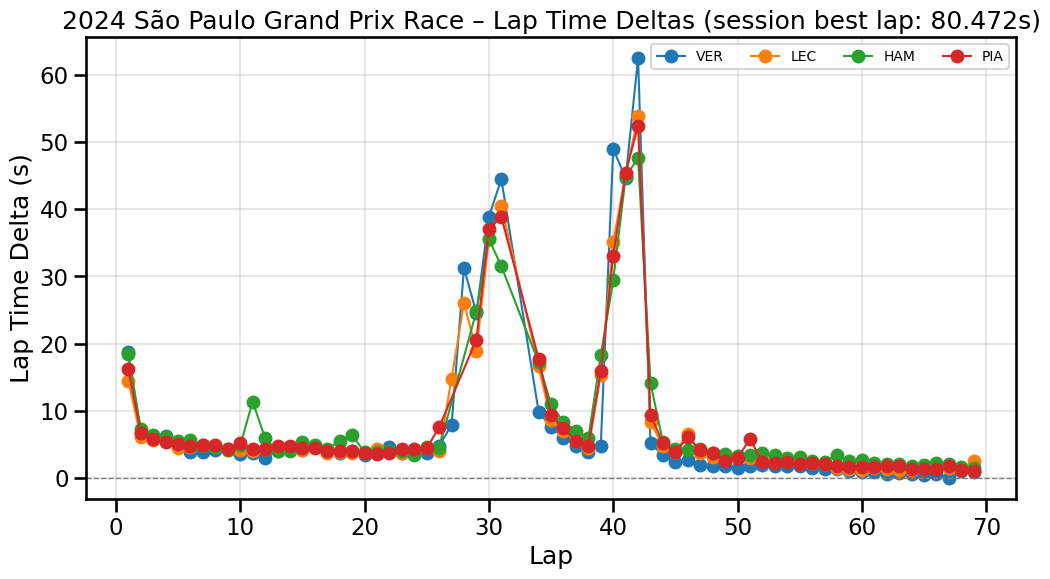

In [ ]:
plot_lap_time_deltas(laps_df, drivers, title_prefix=title_prefix, reference=REFERENCE)

[Saved] /content/outputs/track_position_evolution.png


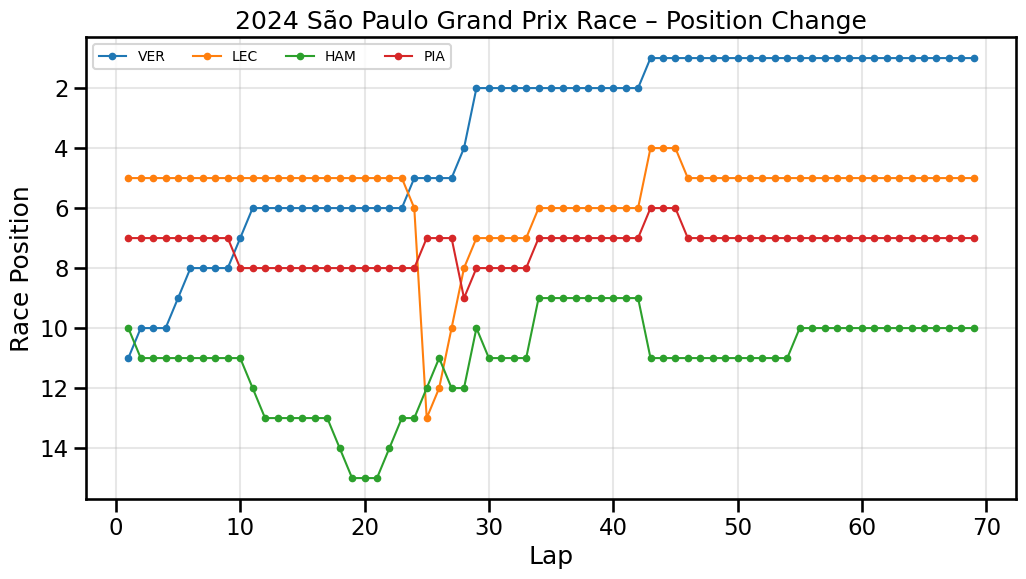

In [ ]:
plot_track_position_evolution(laps_df, drivers, title_prefix=title_prefix)

[Saved] /content/outputs/pit_strategy_timeline.png


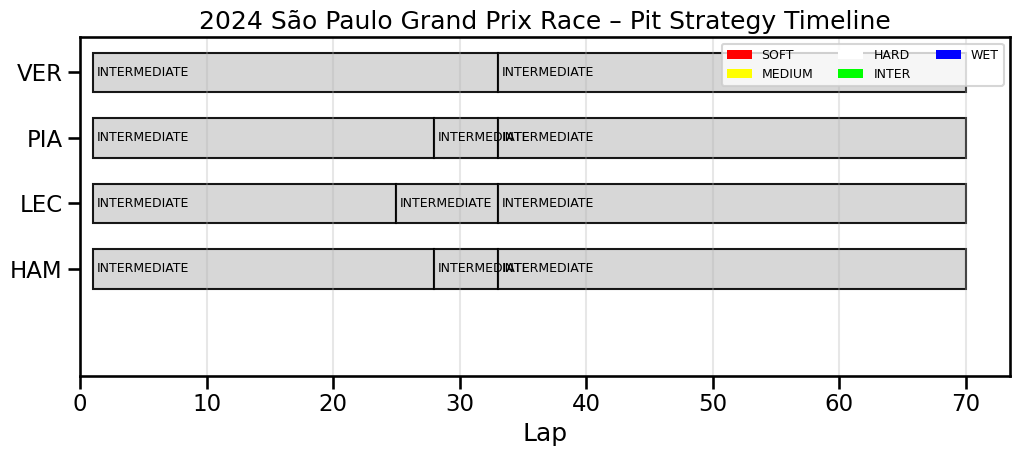

In [ ]:
plot_pit_strategy_timeline(stints_df, title_prefix=title_prefix)